## 1. Setup and Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report


## 2. Load and Preprocess Dataset

In [5]:
df = pd.read_csv("DataCoSupplyChainDataset.csv", encoding='ISO-8859-1')

# Drop irrelevant columns
df.drop(columns=[
    'Product Description', 'Customer Email', 'Customer Fname', 'Customer Lname',
    'Customer Password', 'Customer Street', 'Product Image', 'Order Zipcode'
], inplace=True)

# Target variable: binary delay label
df['delayed'] = (df['Days for shipping (real)'] > df['Days for shipment (scheduled)']).astype(int)

# Encode categorical columns
cat_cols = ['Shipping Mode', 'Customer Segment', 'Order Region', 'Order State', 'Market']
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# Drop rows with any remaining missing data
df.dropna(inplace=True)


## 3. Feature Selection and Split

In [6]:
features = [
    'Shipping Mode', 'Customer Segment', 'Order Region', 'Order State',
    'Days for shipment (scheduled)', 'Order Item Quantity',
    'Order Item Discount Rate', 'Order Item Profit Ratio', 'Sales', 'Order Item Total'
]
X = df[features]
y = df['delayed']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## 4. Random Forest + Hyperparameter Tuning

In [7]:
rf = RandomForestClassifier(random_state=42)
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=10, cv=3, n_jobs=-1, verbose=1, random_state=42)
search.fit(X_train, y_train)
best_rf = search.best_estimator_


Fitting 3 folds for each of 10 candidates, totalling 30 fits


## 5. Evaluation

In [8]:
y_pred = best_rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.6998670507423
Precision: 0.8687725090036015
Recall: 0.5602922674924997
Confusion Matrix:
 [[13689  1749]
 [ 9087 11579]]
Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.89      0.72     15438
           1       0.87      0.56      0.68     20666

    accuracy                           0.70     36104
   macro avg       0.73      0.72      0.70     36104
weighted avg       0.75      0.70      0.70     36104



## 6. Visualizations

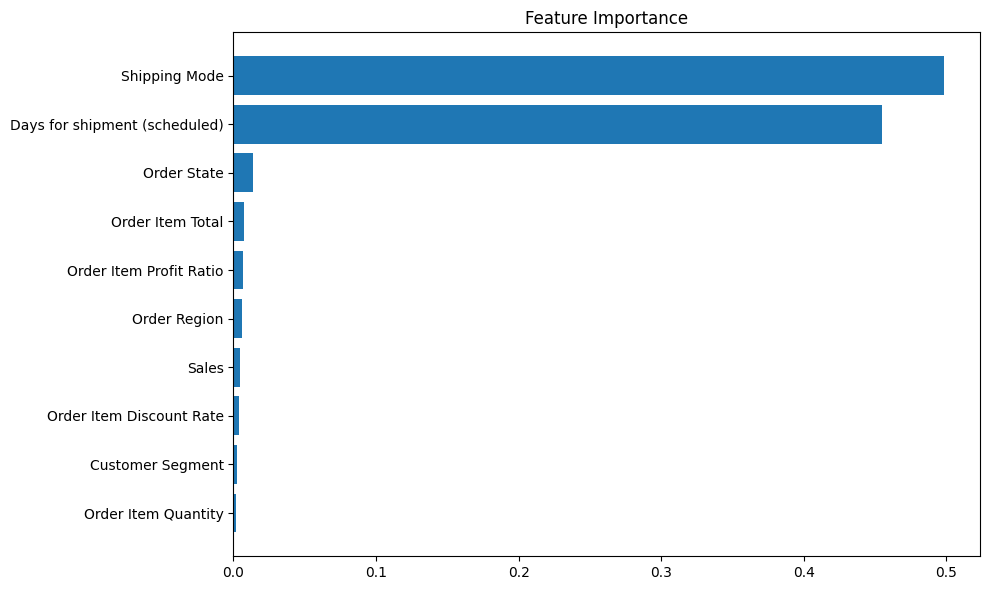

In [9]:
# Feature Importance
importances = best_rf.feature_importances_
sorted_idx = np.argsort(importances)
plt.figure(figsize=(10,6))
plt.barh(range(len(sorted_idx)), importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [features[i] for i in sorted_idx])
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

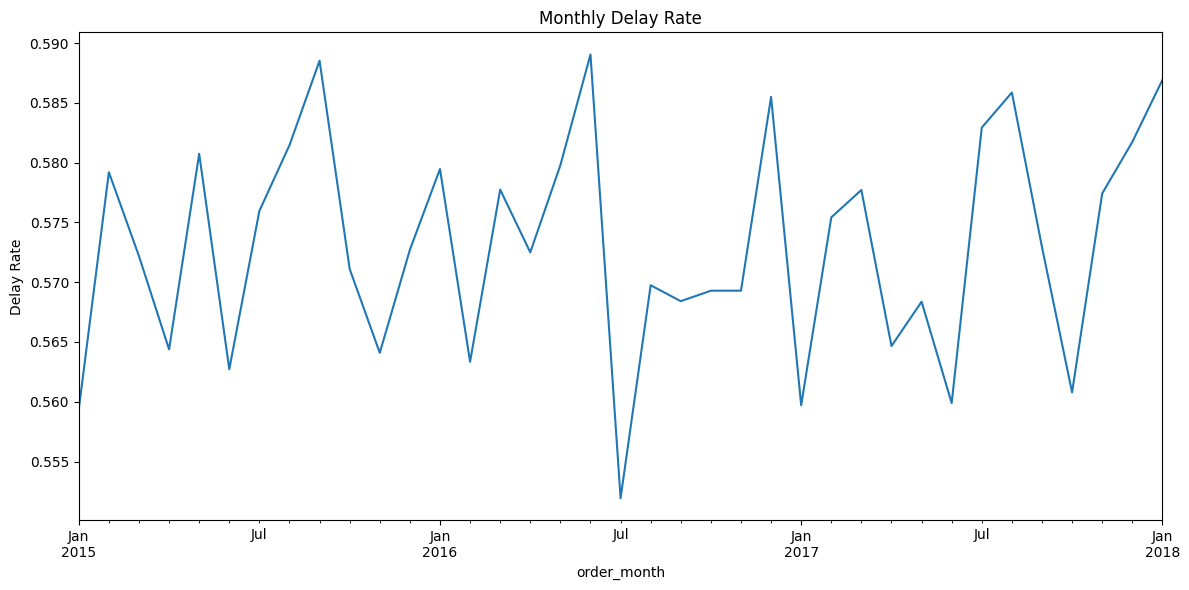

In [11]:
# Delay Trends by Month
df['order date (DateOrders)'] = pd.to_datetime(df['order date (DateOrders)'])
df['order_month'] = df['order date (DateOrders)'].dt.to_period('M')
monthly_delay = df.groupby('order_month')['delayed'].mean()
monthly_delay.plot(figsize=(12,6), title='Monthly Delay Rate')
plt.ylabel("Delay Rate")
plt.tight_layout()
plt.show()

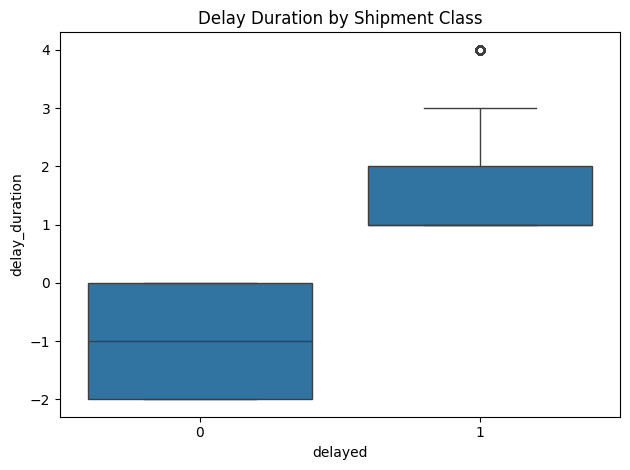

In [12]:
# Boxplot of Delay Duration
df['delay_duration'] = df['Days for shipping (real)'] - df['Days for shipment (scheduled)']
sns.boxplot(x='delayed', y='delay_duration', data=df)
plt.title('Delay Duration by Shipment Class')
plt.tight_layout()
plt.show()

In [13]:
joblib.dump(best_rf, 'random_forest_delay_model.pkl')


['random_forest_delay_model.pkl']